In [1]:
import nilearn
from nibabel.testing import data_path
from nilearn import datasets, plotting, regions
import brainspace
import pandas as pd
import numpy as np
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from nilearn import signal
from brainspace.gradient import GradientMaps
from nilearn.maskers import NiftiLabelsMasker

from brainspace.datasets import load_conte69, load_parcellation
from brainspace.plotting import plot_hemispheres
surf_lh, surf_rh = load_conte69()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

# Preprocessing

### Visualize Schaefer-400 atlas 

In [3]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
lh_parc, rh_parc = load_parcellation('schaefer')

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_23859/941990118.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


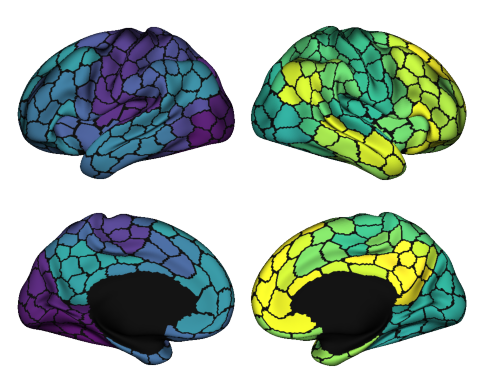

In [4]:
schaefer = Plot(lh, rh)
schaefer.add_layer({'left': lh_parc, 'right': rh_parc}, cbar=False)
schaefer.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='gray',
            as_outline=True, cbar=False)


fig = schaefer.build()
fig.show()

## Load confounds & timeseries

In [196]:
confounds_file = '/Users/VictoriaShevchenko/Documents/PhD/COBRE/sub-A00000909/ses-20110101/func/sub-A00000909_ses-20110101_task-rest_run-1_desc-confounds_timeseries.tsv'
confounds_out_s1 = pd.read_csv(confounds_file, sep = '\t')
confounds_file = '/Users/VictoriaShevchenko/Documents/PhD/COBRE/sub-A00000909/ses-20110101/func/sub-A00000909_ses-20110101_task-rest_run-2_desc-confounds_timeseries.tsv'
confounds_out_s2 = pd.read_csv(confounds_file, sep = '\t')

pd.DataFrame.isna(confounds_out_s1).any().any()

picked_confounds = np.loadtxt('sub-A00018979/confounds.txt', dtype = 'str')

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
confounds_out_s1 = pd.DataFrame(imputer.fit_transform(confounds_out_s1), columns=confounds_out_s1.columns)[picked_confounds[1:]]
confounds_out_s2 = pd.DataFrame(imputer.fit_transform(confounds_out_s2), columns=confounds_out_s2.columns)[picked_confounds[1:]]


True

In [198]:
# Define the paths to the functional images

subj_ts_s1 = '/Users/VictoriaShevchenko/Documents/PhD/COBRE/sub-A00000909/ses-20110101/func/sub-A00000909_ses-20110101_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'
subj_ts_s2 = '/Users/VictoriaShevchenko/Documents/PhD/COBRE/sub-A00000909/ses-20110101/func/sub-A00000909_ses-20110101_task-rest_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'


## Check timeseries of a single voxel

In [116]:
subj_ts_s1_ts = nib.load(subj_ts_s1).get_fdata()

<Figure size 1000x200 with 0 Axes>

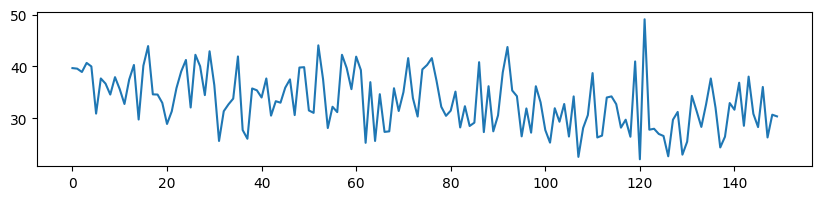

In [108]:
plt.figure(figsize = (10, 2))
plt.plot(subj_ts_s1_ts[20, 20, 20, :])

## Compute timiseries per parcel: Schaefer-400

In [88]:
schaefer_atlas = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=17, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)
schaefer_masker =  NiftiLabelsMasker(labels_img=schaefer_atlas.maps, standardize=True, memory='nilearn_cache', verbose=5) #apply paarcellation to timeseries

 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


In [117]:
confounds_out_s1

csf  white_matter   trans_x  trans_x_derivative1  \
0    1179.214633    805.658380  0.459596            -0.009041   
1    1145.967271    805.822282  0.409468            -0.050128   
2    1137.322691    803.525304  0.424851             0.015383   
3    1134.079758    804.197845  0.412350            -0.012501   
4    1126.898977    803.340001  0.233349            -0.179001   
..           ...           ...       ...                  ...   
145  1132.122480    797.182379 -0.829678            -0.041044   
146  1124.516560    799.013226 -0.843719            -0.014041   
147  1112.081305    795.074533 -0.861729            -0.018010   
148  1127.686802    795.556421 -0.871628            -0.009899   
149  1112.976375    797.822571 -0.887516            -0.015888   

     trans_x_derivative1_power2  trans_x_power2   trans_y  \
0                      0.001634        0.211228  0.073272   
1                      0.002513        0.167664  0.124094   
2                      0.000237        0.180498  0.114132   
3                      0.000156        0.170033  0.104872   
4                      0.032041        0.054452 -0.057285   
..                          ...             ...       ...   
145                    0.001685        0.688366  0.670800   
146                    0.000197        0.711862  0.316325   
147                    0.000324        0.742577  0.564496   
148                    0.000098        0.759735  0.537100   
149                    0.000252        0.787685  0.275400   

     trans_y_derivative1  trans_y_power2  trans_y_derivative1_power2  ...  \
0               0.001357        0.005369                    0.059120  ...   
1               0.050822        0.015399                    0.002583  ...   
2              -0.009962        0.013026                    0.000099  ...   
3              -0.009260        0.010998                    0.000086  ...   
4              -0.162157        0.003282                    0.026295  ...   
..                   ...             ...                         ...  ...   
145             0.346793        0.449973                    0.120265  ...   
146            -0.354475        0.100062                    0.125653  ...   
147             0.248171        0.318656                    0.061589  ...   
148            -0.027396        0.288476                    0.000751  ...   
149            -0.261700        0.075845                    0.068487  ...   

     rot_x_derivative1_power2  rot_x_power2     rot_y  rot_y_derivative1  \
0                2.213297e-06      0.000039 -0.000382      -1.037250e-05   
1                7.110489e-06      0.000080 -0.000907      -5.256030e-04   
2                3.609847e-07      0.000091 -0.000521       3.864300e-04   
3                6.250000e-08      0.000096 -0.000318       2.026830e-04   
4                3.877630e-06      0.000061 -0.000318       5.170000e-07   
..                        ...           ...       ...                ...   
145              1.381734e-05      0.000020 -0.002148       9.971300e-04   
146              1.270467e-06      0.000011 -0.002759      -6.106300e-04   
147              9.080278e-06      0.000040 -0.002064       6.945900e-04   
148              6.152206e-07      0.000050 -0.001866       1.982800e-04   
149              5.246482e-06      0.000023 -0.001927      -6.104000e-05   

     rot_y_derivative1_power2  rot_y_power2     rot_z  rot_z_derivative1  \
0                2.435059e-07  1.456773e-07  0.006496          -0.000141   
1                2.762585e-07  8.231570e-07  0.004813          -0.001683   
2                1.493281e-07  2.712847e-07  0.004546          -0.000267   
3                4.108040e-08  1.012302e-07  0.004449          -0.000097   
4                2.672890e-13  1.009015e-07  0.002486          -0.001963   
..                        ...           ...       ...                ...   
145              9.942682e-07  4.615537e-06 -0.014024          -0.000678   
146              3.728690e-07  7.612136e-06 -0.013667

In [200]:
clean_ts_s1 = schaefer_masker.fit_transform(subj_ts_s1, confounds = confounds_out_s1)
clean_ts_s2 = schaefer_masker.fit_transform(subj_ts_s2, confounds = confounds_out_s2)

[NiftiLabelsMasker.fit_transform] loading data from /Users/VictoriaShevchenko/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/Users/VictoriaShevchenko/Documents/PhD/COBRE/sub-A00000909/ses-20110101/func/sub-A00000909_ses-20110101_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/Users/VictoriaShevchenko/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine'

In [202]:
clean_ts_s1.shape
clean_ts_s2.shape

(150, 400)

(150, 400)

## Check the frequency field. Not good.

Text(0.5, 0, 'Frequency (Hz)')

Text(0, 0.5, 'Power Spectral Density')

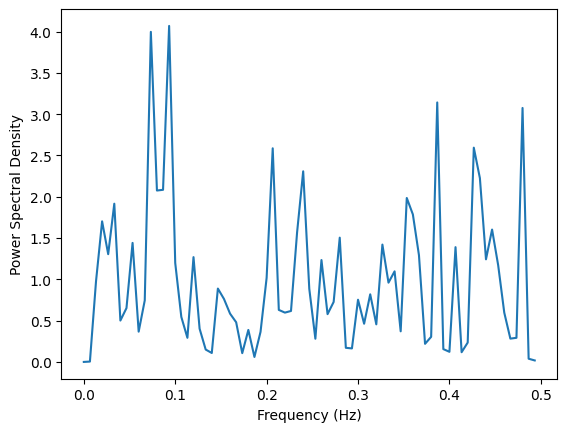

In [74]:
# Compute the FFT of the timeseries along the time axis (axis=0)
fft_data = np.fft.fft(clean_ts_s1, axis=0)

# Compute the FFT of the timeseries along the time axis (axis=0)
fft_data = np.fft.fft(clean_ts_s1, axis=0)

# Compute the power spectral density (PSD) of the FFT data
freqs = np.fft.fftfreq(clean_ts_s1.shape[0])
psd = np.abs(fft_data)**2 / clean_ts_s1.shape[0]

# Plot the frequency field
plt.plot(freqs[:clean_ts_s1.shape[0]//2], psd[:clean_ts_s1.shape[0]//2, 0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.show()

## Clean the signal

In [120]:
clean_ts_s1 = signal.clean(clean_ts_s1, t_r=2, low_pass=0.08, high_pass=0.01, standardize=True, detrend=True)
clean_ts_s2 = signal.clean(clean_ts_s2, t_r=2, low_pass=0.08, high_pass=0.01, standardize=True, detrend=True)

In [13]:
clean_ts = np.row_stack([clean_ts_s1[10:], clean_ts_s2[10:]])

## Check the frequency field. That's more like it.

Text(0.5, 0, 'Frequency (Hz)')

Text(0, 0.5, 'Power Spectral Density')

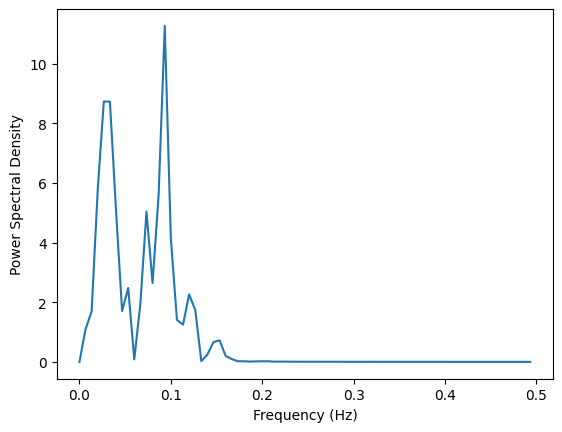

In [76]:
# Compute the FFT of the timeseries along the time axis (axis=0)
fft_data = np.fft.fft(clean_ts_s1, axis=0)

# Compute the FFT of the timeseries along the time axis (axis=0)
fft_data = np.fft.fft(clean_ts_s1, axis=0)

# Compute the power spectral density (PSD) of the FFT data
freqs = np.fft.fftfreq(clean_ts_s1.shape[0])
psd = np.abs(fft_data)**2 / clean_ts_s1.shape[0]

# Plot the frequency field
plt.plot(freqs[:clean_ts_s1.shape[0]//2], psd[:clean_ts_s1.shape[0]//2, 0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.show()

## Check 1 voxel and check the parcellation.

<Figure size 1000x200 with 0 Axes>

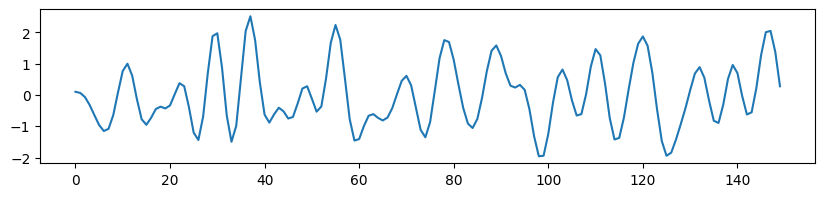

In [77]:
plt.figure(figsize = (10, 2))
plt.plot(clean_ts_s1[:, 140])

[NiftiLabelsMasker.inverse_transform] computing image from signals


/Users/VictoriaShevchenko/.local/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


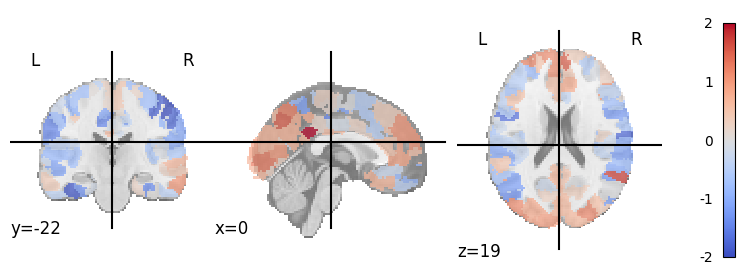

In [67]:
plotting.plot_roi(schaefer_masker.inverse_transform(clean_ts_s1).slicer[:,:,:,100], colorbar=True, cmap = "coolwarm", threshold = 0.000001)

# Extract Gradients

### Load Schaefer-400 on fsLR 32k surface.
#### Map parcellated timeseries onto fsLR surface.

In [46]:
schaefer_labels = load_parcellation('schaefer', scale=400, join=True)

#### pick subject

In [79]:
subject = "A00019293"

In [80]:
subj_clean_ts = np.load(f"clean_data/sub-{subject}/func/sub-{subject}_task-rest_space-MNI152NLin2009cAsym_res-2_desc-clean_bold.npy")
subj_clean_ts = np.row_stack(subj_clean_ts)

In [81]:
subj_correlation_matrix = np.corrcoef(subj_clean_ts.T)

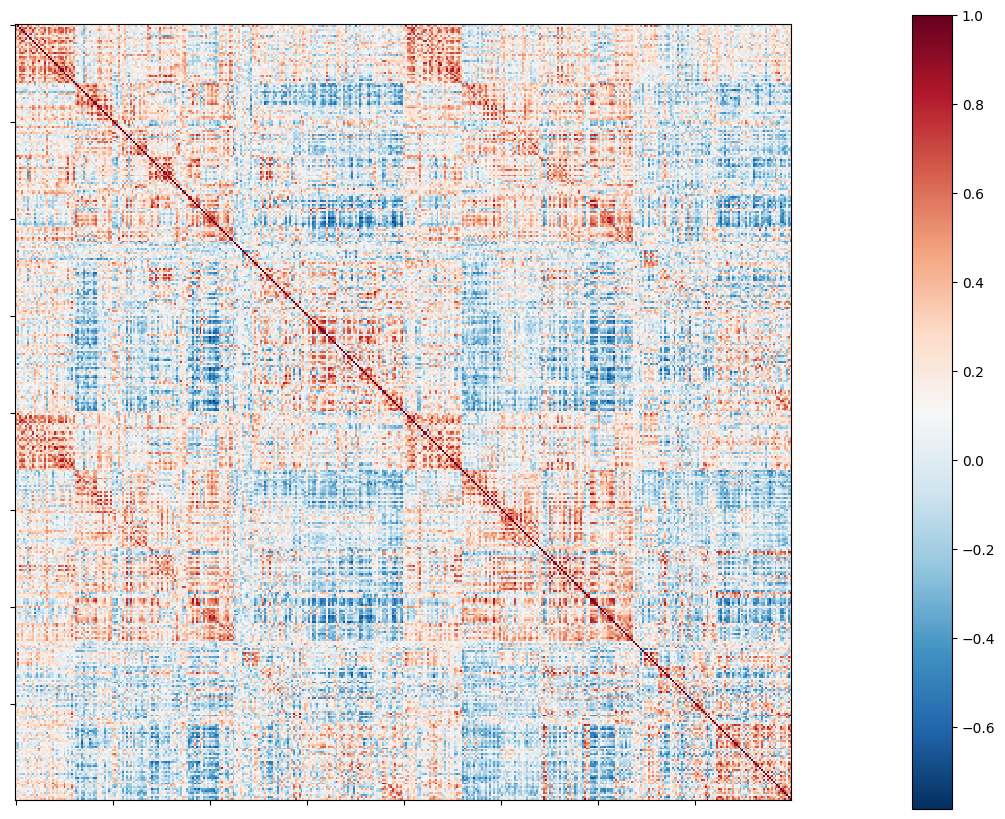

In [82]:
corr_plot = plotting.plot_matrix(subj_correlation_matrix, figure=(10, 10))

In [7]:
gm = GradientMaps(n_components=3, kernel = "cosine", approach= 'pca')
gm.fit(subj_correlation_matrix)

GradientMaps(approach='pca', kernel='cosine', n_components=3)

In [10]:
grad_subj = [None] * 3

for i, g in enumerate(gm.gradients_.T):
    grad_subj[i] = map_to_labels(g, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

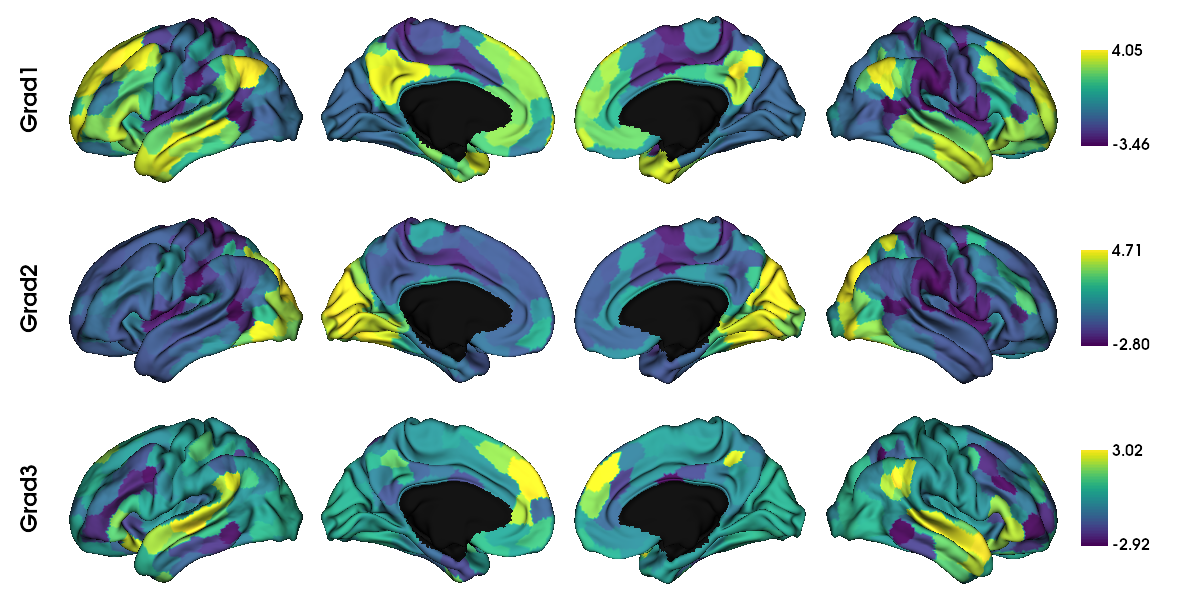

In [11]:
plot_hemispheres(surf_lh, surf_rh, array_name=grad_subj, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)

# Schaefer 400: Group Gradients

In [29]:
subjects = np.loadtxt("COBRE_subjects.txt", dtype = str)[1:]


In [31]:
ts = []
for subject in subjects:
    subject_ts_path = f"/Users/VictoriaShevchenko/Documents/PhD/COBRE/clean_data/sub-{subject}/func/sub-{subject}_task-rest_space-MNI152NLin2009cAsym_res-2_desc-clean_bold.npy"
    subject_ts = np.load(subject_ts_path)
    subject_ts = np.row_stack(subject_ts)
    ts.append(subject_ts)

In [40]:
conn_matrices = []
for subject_ts in ts:
    #conn = np.corrcoef(subject_ts.T)
    conn = np.arctanh(np.corrcoef(subject_ts.T))
    conn_matrices.append(conn)
conn_matrices = np.asarray(conn_matrices)

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_57549/141645875.py:4: RuntimeWarning: divide by zero encountered in arctanh
  conn = np.arctanh(np.corrcoef(subject_ts.T))


In [41]:
conn_matrices.shape

(72, 400, 400)

In [42]:
conn_mean = np.mean(conn_matrices, axis = 0)
conn_mean = np.tanh(conn_mean)
conn_mean.shape

(400, 400)

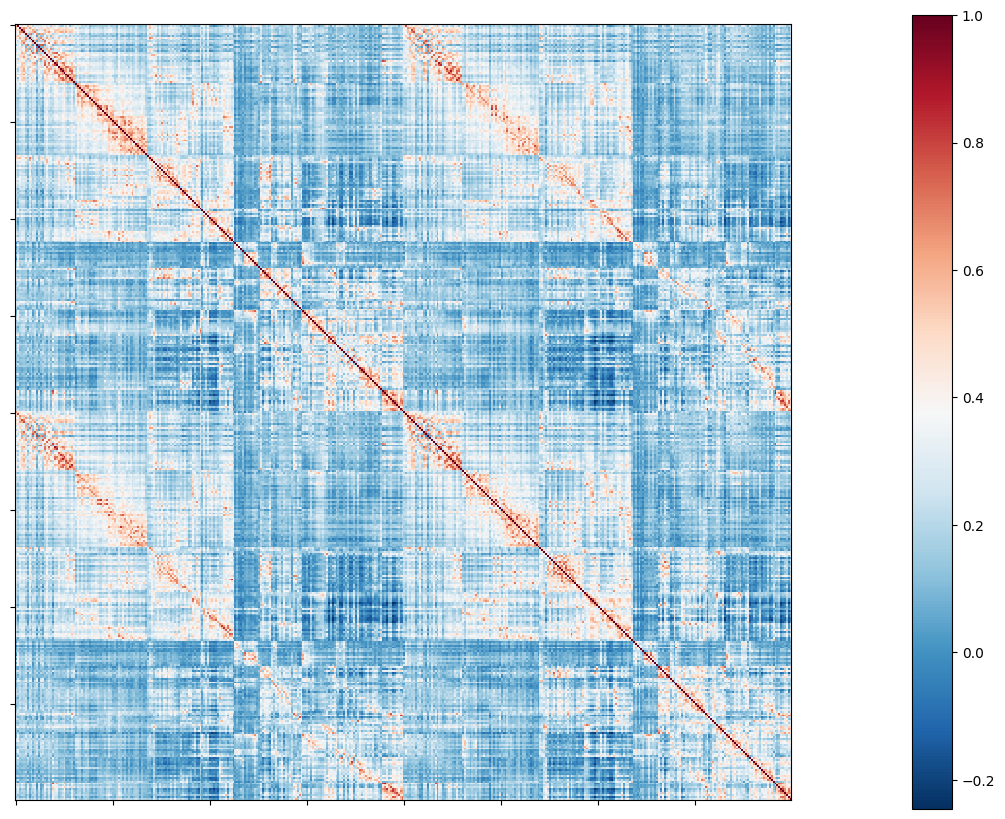

In [43]:
corr_plot = plotting.plot_matrix(conn_mean, figure=(10, 10))

In [47]:
gm = GradientMaps(n_components=3, kernel = "cosine", approach= 'pca')
gm.fit(conn_mean)

GradientMaps(approach='pca', kernel='cosine', n_components=3)

In [48]:
scz_group_grad = [None] * 3

for i, g in enumerate(gm.gradients_.T):
    scz_group_grad[i] = map_to_labels(g, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

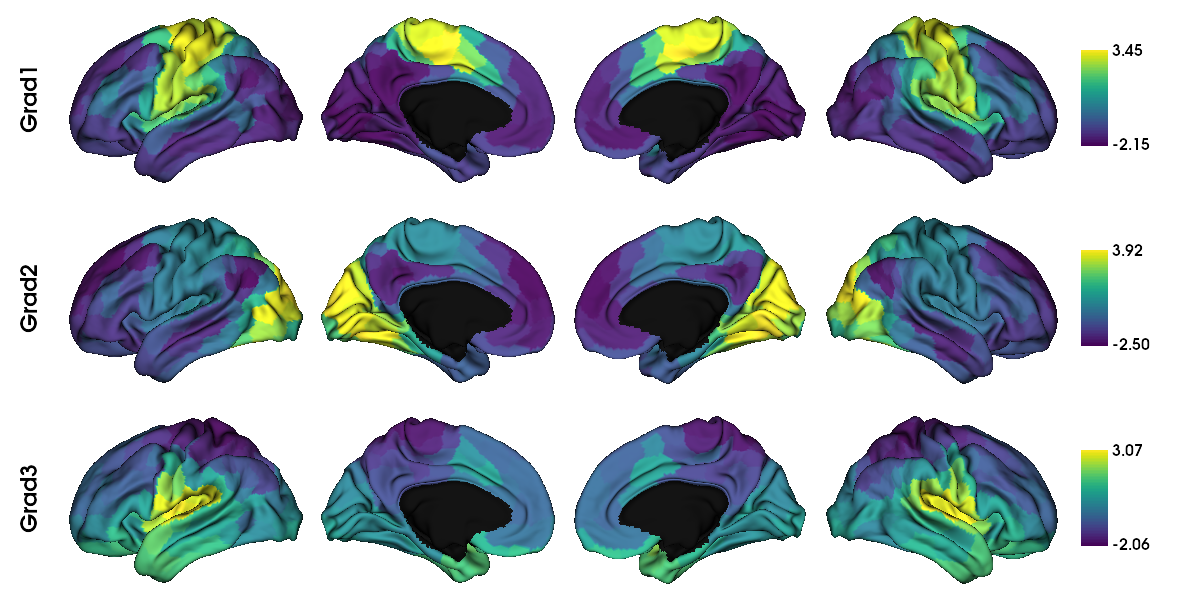

In [49]:
plot_hemispheres(surf_lh, surf_rh, array_name=scz_group_grad, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)

In [84]:
scz_group_grad_df = pd.DataFrame(gm.gradients_, columns = ["Grad 1", "Grad 2", "Grad 3"])

In [86]:
import plotly.express as px

fig = px.scatter_3d(scz_group_grad_df, x="Grad 2", y="Grad 3", z="Grad 1",
              color="Grad 2", color_continuous_scale=px.colors.sequential.Viridis) #color_continuous_scale=['blue','yellow', 'red']

fig.update_traces(marker_size = 3)

fig.update_layout(scene = dict(
                    xaxis = dict(
                         backgroundcolor="white",
                         gridcolor="rgb(220, 220, 220)",
                         showbackground=True,
                         zerolinecolor="white",
                         title = "Gradient 2",),
                    yaxis = dict(
                        backgroundcolor="white",
                        gridcolor="rgb(220, 220, 220)",
                        showbackground=True,
                        zerolinecolor="white",
                        title = "Gradient 3",),
                    zaxis = dict(
                        backgroundcolor="white",
                        gridcolor="rgb(220, 220, 220)",
                        showbackground=True,
                        zerolinecolor="white",
                        title = "Gradient 1",),),
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )

# Schaefer 1000

In [90]:
ts = []
for subject in subjects:
    subject_ts_path = f"/Users/VictoriaShevchenko/Documents/PhD/COBRE/clean_data/schaefer1000/sub-{subject}/func/sub-{subject}_task-rest_space-MNI152NLin2009cAsym_res-2_schaefer1000_desc-clean_bold.npy"
    subject_ts = np.load(subject_ts_path)
    subject_ts = np.row_stack(subject_ts)
    ts.append(subject_ts)

In [91]:
conn_matrices = []
for subject_ts in ts:
    #conn = np.corrcoef(subject_ts.T)
    conn = np.arctanh(np.corrcoef(subject_ts.T))
    conn_matrices.append(conn)
conn_matrices = np.asarray(conn_matrices)

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_57549/141645875.py:4: RuntimeWarning:

divide by zero encountered in arctanh



In [92]:
conn_mean = np.mean(conn_matrices, axis = 0)
conn_mean = np.tanh(conn_mean)
conn_mean.shape

(1000, 1000)

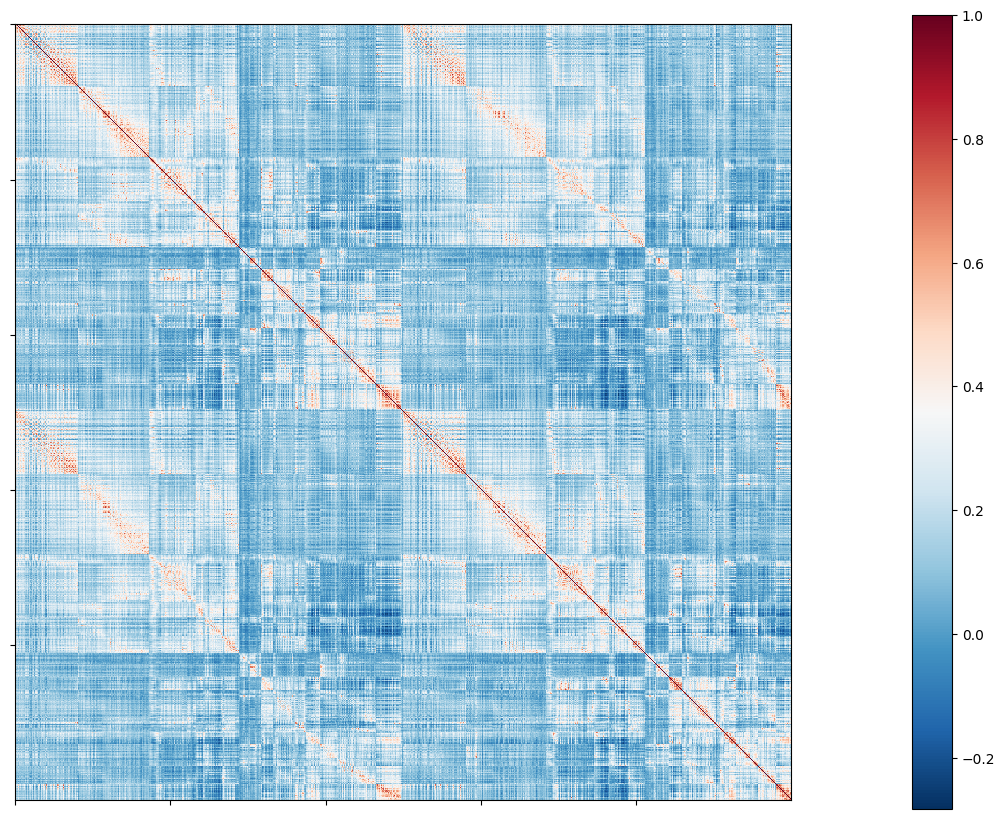

In [93]:
corr_plot = plotting.plot_matrix(conn_mean, figure=(10, 10))

In [94]:
gm = GradientMaps(n_components=3, kernel = "cosine", approach= 'pca')
gm.fit(conn_mean)

GradientMaps(approach='pca', kernel='cosine', n_components=3)

In [95]:
scz_group_grad_schaefer1000 = [None] * 3

for i, g in enumerate(gm.gradients_.T):
    scz_group_grad_schaefer1000[i] = map_to_labels(g, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

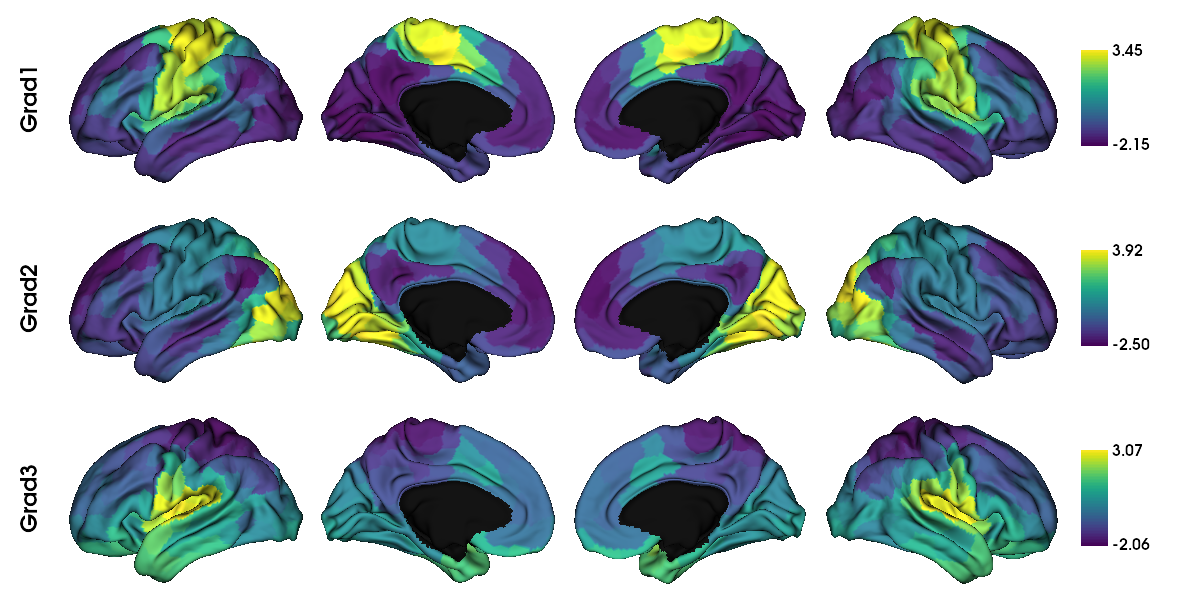

In [96]:
plot_hemispheres(surf_lh, surf_rh, array_name=scz_group_grad, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)

In [97]:
scz_group_grad_schaefer1000_df = pd.DataFrame(gm.gradients_, columns = ["Grad 1", "Grad 2", "Grad 3"])

In [99]:
fig = px.scatter_3d(scz_group_grad_schaefer1000_df, x="Grad 2", y="Grad 3", z="Grad 1",
              color="Grad 2", color_continuous_scale=px.colors.sequential.Viridis) #color_continuous_scale=['blue','yellow', 'red']

fig.update_traces(marker_size = 2)

fig.update_layout(scene = dict(
                    xaxis = dict(
                         backgroundcolor="white",
                         gridcolor="rgb(220, 220, 220)",
                         showbackground=True,
                         zerolinecolor="white",
                         title = "Gradient 2",),
                    yaxis = dict(
                        backgroundcolor="white",
                        gridcolor="rgb(220, 220, 220)",
                        showbackground=True,
                        zerolinecolor="white",
                        title = "Gradient 3",),
                    zaxis = dict(
                        backgroundcolor="white",
                        gridcolor="rgb(220, 220, 220)",
                        showbackground=True,
                        zerolinecolor="white",
                        title = "Gradient 1",),),
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )

# Neurotypical Controls

In [100]:
subjects = np.loadtxt("COBRE_control_subjects.txt", dtype = str)[1:]

# Resample Margulies grads

In [34]:
marguluies_grads = np.load("/Users/VictoriaShevchenko/Documents/PhD/margulies_grads_32K.npy")


In [ ]:
import hcp_utils as hcp
margulies_grads_labeled = np.array([hcp.cortex_data(i) for i in marguluies_grads])
margulies_grads_labeled.shape

In [ ]:
margulies_grads_schaefer400 = reduce_by_labels(margulies_grads_labeled, labels=schaefer_labels)

In [35]:

fig = px.scatter_3d(x=margulies_grads_schaefer400[1], y=margulies_grads_schaefer400[2], z=margulies_grads_schaefer400[0],
              color=margulies_grads_schaefer400[0], color_continuous_scale=px.colors.sequential.Viridis) #color_continuous_scale=['blue','yellow', 'red']

fig.update_traces(marker_size = 3)

fig.update_layout(scene = dict(
                    xaxis = dict(
                         backgroundcolor="white",
                         gridcolor="rgb(220, 220, 220)",
                         showbackground=True,
                         zerolinecolor="white",
                         title = "Gradient 2",),
                    yaxis = dict(
                        backgroundcolor="white",
                        gridcolor="rgb(220, 220, 220)",
                        showbackground=True,
                        zerolinecolor="white",
                        title = "Gradient 3",),
                    zaxis = dict(
                        backgroundcolor="white",
                        gridcolor="rgb(220, 220, 220)",
                        showbackground=True,
                        zerolinecolor="white",
                        title = "Gradient 1",),),
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )